# Q

#####  Potential problems:
*  SO Many slope values os close to 90: what does it mean?

TODO:
Try binning calories_per_ha: categorical prob ? dfTransformed = pd.cut(df[col], bins=5, labels=[1, 2, 3, 4, 5])

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures


from scipy import stats

#import hazelbean as hb
#L = hb.get_logger()

import seaborn as sns
import matplotlib 
%matplotlib inline

import matplotlib.pyplot as plt

import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', 500)


# Input data preprocessing 
to be in Annex of the code

In [ ]:
## Resampling pop data
from osgeo import gdal, ogr, gdalconst, osr

def reproject_raster(input_fn, match_fn, output_fn,
                     interpolation_scheme=gdalconst.GRA_Bilinear,
                     output_type=gdalconst.GDT_Float32,
                    NoData =-99999):

    # Source
    src_filename = input_fn
    src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()
    src_geotrans = src.GetGeoTransform()

    # We want a section of source that matches this:
    match_filename = match_fn
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize

    # Output / destination
    dst_filename = output_fn
    dst = gdal.GetDriverByName('GTiff').Create(dst_filename,
                                               wide,                   # number of columns
                                               high,                   # number of columns
                                               1,                      # number of bands
                                               output_type)  # datatype of the raster
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection(match_proj)
    dst.GetRasterBand(1).SetNoDataValue(NoData)

    # Do the work
    gdal.ReprojectImage(src, dst, src_proj, match_proj, interpolation_scheme)

    del dst # Flush
    return None

In [ ]:
reproject_raster('../ipbes_invest_crop_yield_project/input/Demographic/ciesin/gpw_v4_population_count_rev10_2000_30_sec.tif',
                 '../ipbes_invest_crop_yield_project/input/Cartographic/country_ids.tif',
                 '../ipbes_invest_crop_yield_project/input/Demographic/ciesin/gpw_population.tif',
                 output_type=gdalconst.GDT_Int32)

In [ ]:
reproject_raster('../ipbes_invest_crop_yield_project/input/Climate/Koeppen-Geiger/climate_zones_wrong_proj.tif',
                 '../ipbes_invest_crop_yield_project/input/Cartographic/country_ids.tif',
                 '../ipbes_invest_crop_yield_project/input/Climate/Koeppen-Geiger/climate_zones.tif',
                 output_type=gdalconst.GDT_Int32)

In [173]:
##Things to be added in load_data
df = load_data()

In [ ]:
df = df.rename(columns={'bio12': 'precip', 'bio1': 'temperature',
                       'minutes_to_market_5m':'min_to_market',
                       'gdp_per_capita_2000_5m':'gdp_per_capita',
                       'gdp_2000':'gdp'})

df['log_precip'] = df['precip'].apply(lambda x: np.log(x) if x!=0 else 0)
df['log_altitude'] = df['altitude'].apply(lambda x:np.log(x) if x!=0 else 0)
df['log_gdp'] = df['gdp'].apply(lambda x:np.log(x) if x!=0 else 0)
df['log_gdp_per_capita'] = df['gdp_per_capita'].apply(lambda x:np.log(x) if x!=0 else 0)
df['log_min_to_market'] = df['min_to_market'].apply(lambda x:np.log(x) if x!=0 else 0)


df['slope'] = df['slope'].replace({0:np.nan}) #143 NaN in 'slope' variable

for soil_var in ['workability_index', 'toxicity_index','rooting_conditions_index', 'oxygen_availability_index',
       'nutrient_retention_index', 'nutrient_availability_index','excess_salts_index']:
    df[soil_var] = df[soil_var].replace({255:np.nan}) 

## TODO figure out how to encode soil variables

df
    
df = df.dropna()

In [ ]:
df.head()

In [ ]:
for var in df.columns:
    fig,ax = plt.subplots()
    df[var].plot(kind='kde',ax=ax);
    ax.set_xlabel(var);

# Load dataset

In [7]:
def load_data(subset=True):
    #L.info('Loading data')
    crop_types_df = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/aggregate_crops_by_type/aggregated_crop_data.csv')
    df_land = pd.read_csv('../ipbes_invest_crop_yield_project/intermediate/create_baseline_regression_data/baseline_regression_data.csv')
    #L.info('Data loaded')

    df = crop_types_df.merge(df_land,how='outer',on='pixel_id')
    #L.info('Data merged')

    if subset==True:
        df = df.sample(frac=0.02, replace=False, weights=None, random_state=None, axis=0)

    elif subset==False: #Save validation data
        x = df.drop(['calories_per_ha'], axis=1)
        y = df['calories_per_ha']
        X, X_validation, Y, y_validation = train_test_split(x, y)
        df = X.merge(Y,how='outer',left_index=True,right_index=True)

    #Remove cal_per_ha per crop type for now
    df = df.drop(labels=['c3_annual_calories_per_ha', 'c3_perennial_calories_per_ha',
           'c4_annual_calories_per_ha', 'c4_perennial_calories_per_ha',
           'nitrogen_fixer_calories_per_ha'], axis=1)

    #Remove helper columns (not features)
    df = df.drop(labels=['Unnamed: 0', 'country_ids',
           'ha_per_cell_5m'], axis=1)

    # Rename cols
    df = df.rename(columns={'bio12': 'precip', 'bio1': 'temperature',
                                'minutes_to_market_5m': 'min_to_market',
                                'gdp_per_capita_2000_5m': 'gdp_per_capita',
                                'gdp_2000': 'gdp'})
    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
        
    # Drop NaN
    df = df.dropna()
    df = df[df['calories_per_ha'] != 0]    
    
    #Encode climate zones (as str)
    climate_zones_map = {1:'Af',2:'Am',3:'Aw',
                     5:'BWk',4:'BWh',7:'BSk',6:'BSh',
                     14:'Cfa',15:'Cfb',16:'Cfc',8:'Csa',
                     9:'Csb',10:'Csc',11:'Cwa',12:'Cwb',13:'Cwc',
                     25:'Dfa',26:'Dfb',27:'Dfc',28:'Dfd',17:'Dsa',18:'Dsb',19:'Dsc',
                     20:'Dsd',21:'Dwa',22:'Dwb',23:'Dwc',24:'Dwd',
                     30:'EF',29:'ET'}
    df['climate_zones'] = df['climate_zones'].map(climate_zones_map)
    
    # Encode climate zones as dummies
    climate_dummies_df = pd.get_dummies(df['climate_zones'])
    for col in climate_dummies_df.columns:
        climate_dummies_df = climate_dummies_df.rename({col:str('climatezone_'+col)},axis=1)
    
    df = df.merge(climate_dummies_df, right_index=True,left_index=True)
    df = df.drop('climate_zones',axis=1)
    
    # Log some skewed variables
    df['calories_per_ha'] = df['calories_per_ha'].apply(lambda x: np.log(x) if x != 0 else 0)

    for col in ['gdp_per_capita','altitude', 'min_to_market', 'gpw_population']:
        df[str('log_'+col)] = df[col].apply(lambda x: np.log(x) if x != 0 else 0)


    # Encode properly NaNs
    df['slope'] = df['slope'].replace({0: np.nan})  # 143 NaN in 'slope' variable
    for soil_var in ['workability_index', 'toxicity_index', 'rooting_conditions_index', 'oxygen_availability_index',
                     'nutrient_retention_index', 'nutrient_availability_index', 'excess_salts_index']:
        df[soil_var] = df[soil_var].replace({255: np.nan})
            
    df = df.set_index('pixel_id')

    return df

In [8]:
df = load_data()

### Look at distributions

In [ ]:
for var in df.columns:
    fig,ax = plt.subplots()
    df[var].plot(kind='kde',ax=ax);
    ax.set_xlabel(var);

In [ ]:
fig,ax = plt.subplots(figsize=(20,5));
sns.distplot(df[df['calories_per_ha']!=0]['calories_per_ha'],ax=ax);

#Lines at mean, 75%, 90%, and 99%
plt.axvline(df['calories_per_ha'].mean(), color='k', linestyle='dashed', linewidth=1);
plt.axvline(df['calories_per_ha'].quantile(0.75), color='b', linestyle='dashed', linewidth=1);
plt.axvline(df['calories_per_ha'].quantile(0.9), color='r', linestyle='dashed', linewidth=1);
plt.axvline(df['calories_per_ha'].quantile(0.99), color='g', linestyle='dashed', linewidth=1);

### Polynomial features

In [ ]:
def make_polynomial(df, degree = 2, interaction_terms = True):
#'''Returns a new dataFrame with added polynomial terms degree >= 2'''


    if interaction_terms == False:
        x = df.drop(['calories_per_ha','climate_zones'], axis=1)
        y = df['calories_per_ha']

        for deg in range(2,degree+1):
            for col in x.columns:
                x[str(col+'^'+str(deg))] = x[col].apply(lambda x:x**deg)
        
        Poly_df = x.merge(pd.DataFrame(y),right_index=True,left_index=True)

    if interaction_terms == True:
        x = df.drop(['calories_per_ha','climate_zones'], axis=1)
        y = df['calories_per_ha'].reset_index()

        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X2 = poly.fit_transform(x)

        Poly_df = pd.DataFrame(data = np.concatenate((y.as_matrix(),X2),axis=1),
                               columns = ['pixel_id','calories_per_ha'] +
                               poly.get_feature_names((df.drop(['calories_per_ha','climate_zones'], axis=1)).columns))

        Poly_df = Poly_df.set_index('pixel_id')

    return Poly_df


### Store results 

In [ ]:
results= pd.DataFrame(columns=['Model','num_features','Features','MSE','R2'])

In [134]:
results

,Model,num_features,Features,MSE,R2
0,Linear Regression,5,"[toxicity_index, rooting_conditions_index, nut...",-0.008604,0.121383
1,Linear Regression,6,"[toxicity_index, rooting_conditions_index, nut...",-0.008512,0.131148
2,Linear Regression,7,"[toxicity_index, rooting_conditions_index, nut...",-0.008494,0.132957
3,Linear Regression,8,"[toxicity_index, rooting_conditions_index, nut...",-0.008493,0.133093
4,Linear Regression,9,"[toxicity_index, rooting_conditions_index, nut...",-0.008494,0.132958
5,Linear Regression,10,"[toxicity_index, rooting_conditions_index, nut...",-0.008215,0.161261
6,Linear Regression,11,"[toxicity_index, rooting_conditions_index, nut...",-0.008182,0.164579
7,Linear Regression,12,"[toxicity_index, rooting_conditions_index, nut...",-0.008184,0.164461
8,Linear Regression,13,"[toxicity_index, rooting_conditions_index, nut...",-0.008175,0.165415
9,Linear Regression,14,"[toxicity_index, rooting_conditions_index, pro...",-0.008175,0.165405


In [ ]:
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### - - - - - - - - - - - - - - - -  Linear regression - - - - - - - - - - - - - - - - 
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


regression = LinearRegression()

model = 'Linear Reg'

dataframe = df
        

# Iterate over ≠ numbers of features
for num_features in range (5,10):

    ## RFE - Features selection
    selector = RFE(regression, num_features, step=1)

    x = dataframe.drop(['calories_per_ha','climate_zones'], axis=1) ## TODO climate_zones encode One Hot Encoder
    y = dataframe['calories_per_ha']
    X, X_test, Y, Y_test = train_test_split(x, y)

    X_RFE = selector.fit_transform(X,Y)

    features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
    features_selected.append('calories_per_ha')
    scores = do_regression(regression,dataframe[features_selected])
    R2_score = scores[0]
    MSE_score = scores[1]
    MAE_score = scores[2]

    results = results.append({'Model': model,
                              'num_features':num_features,
                              'Features':features_selected,
                              'R2':R2_score,
                              'MSE':MSE_score},
                             ignore_index=True)
    

In [133]:
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### - - - - - - - - - - - - - - - -  Polynomial regression - - - - - - - - - - - - - - - - 
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -



regression = LinearRegression()

for interaction_terms in [False,True]:
    for degree in [2,3]:
        
        print('Running Polynomial of degree ' + str(degree)+ interaction_terms*(' with interaction terms'))
        
        
        model = str('Poly deg'+str(degree)+interaction_terms*' w/ interact')

        dataframe = make_polynomial(df)

        

        # Iterate over ≠ numbers of features
        for num_features in range (5,10):
            
            print('  Doing regression with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)

            x = dataframe.drop(['calories_per_ha'], axis=1) ## TODO climate_zones encode One Hot Encoder
            y = dataframe['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)

            X_RFE = selector.fit_transform(X,Y)

            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            features_selected.append('calories_per_ha')
            scores = do_regression(regression,dataframe[features_selected])
            R2_score = scores[0]
            MSE_score = scores[1]
            MAE_score = scores[2]

            results = results.append({'Model': model,
                                      'num_features':num_features,
                                      'Features':features_selected,
                                      'R2':R2_score,
                                      'MSE':MSE_score},
                                     ignore_index=True)
            
            print('  ... done')
    

Running Polynomial of degree 2
Doing regression with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 6 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 7 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 8 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 9 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Running Polynomial of degree 3
Doing regression with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 6 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 7 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 8 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 9 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Running Polynomial of degree 2 with interaction terms
Doing regression with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 6 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 7 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 8 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 9 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Running Polynomial of degree 3 with interaction terms
Doing regression with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 6 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 7 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 8 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


... done
Doing regression with 9 features ...
... done


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [193]:
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
### - - - - - - - - - - - - - - - - -  XGB - - - - - - - - - - - - - - - - - - - - - - - 
### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

model = 'XGB'


regression = xgb.XGBRegressor()

print('Running XGBoost')

# Iterate over ≠ numbers of features
for num_features in range (5,6):
    
    print('    with '+str(num_features)+ ' features ...')
    
    ## RFE - Features selection
    selector = RFE(regression, num_features, step=1)

    x = df.drop(['calories_per_ha','climate_zones'], axis=1) ## TODO climate_zones encode One Hot Encoder
    y = df['calories_per_ha']
    X, X_test, Y, Y_test = train_test_split(x, y)

    X_RFE = selector.fit_transform(X,Y)

    features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
    features_selected.append('calories_per_ha')
    scores = do_regression(regression,df[features_selected])
    R2_score = scores[0]
    MSE_score = scores[1]
    MAE_score = scores[2]
    
    results = results.append({'Model': model,
                              'num_features':num_features,
                              'Features':features_selected,
                              'R2':R2_score,
                              'MSE':MSE_score},
                             ignore_index=True)
    
    
    print('    ... done')
    

/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [194]:
results

,Model,num_features,Features,MSE,R2
0,Linear Regression,5,"[toxicity_index, rooting_conditions_index, nut...",-0.008604,0.121383
1,Linear Regression,6,"[toxicity_index, rooting_conditions_index, nut...",-0.008512,0.131148
2,Linear Regression,7,"[toxicity_index, rooting_conditions_index, nut...",-0.008494,0.132957
3,Linear Regression,8,"[toxicity_index, rooting_conditions_index, nut...",-0.008493,0.133093
4,Linear Regression,9,"[toxicity_index, rooting_conditions_index, nut...",-0.008494,0.132958
5,Linear Regression,10,"[toxicity_index, rooting_conditions_index, nut...",-0.008215,0.161261
6,Linear Regression,11,"[toxicity_index, rooting_conditions_index, nut...",-0.008182,0.164579
7,Linear Regression,12,"[toxicity_index, rooting_conditions_index, nut...",-0.008184,0.164461
8,Linear Regression,13,"[toxicity_index, rooting_conditions_index, nut...",-0.008175,0.165415
9,Linear Regression,14,"[toxicity_index, rooting_conditions_index, pro...",-0.008175,0.165405


### Automated functions to make regressions

In [9]:
def do_regression(regression,dataframe):
    ##Must make dummies for categorical variable climate_zone
    # dataframe = pd.get_dummies(dataframe, columns=['climate_zone'])
    # Or just drop column if don't want dummies: x = x.drop(['climate_zone'], axis=1)

    x = dataframe.drop(['calories_per_ha'], axis=1)
    y = dataframe['calories_per_ha']

    ### Cross validation scores
    r2_scores = cross_val_score(regression, x, y, cv=10,scoring='r2')
    mse_scores = cross_val_score(regression, x, y, cv=10, scoring='neg_mean_squared_error')
    mae_scores = cross_val_score(regression, x, y, cv=10, scoring='neg_mean_absolute_error')
    
    return [np.mean(r2_scores),np.mean(mse_scores),np.mean(mae_scores)]

In [ ]:
def compare_predictions(regression,dataframe,show_df=True,show_plot=True):
    x = dataframe.drop(['calories_per_ha','climate_zones'], axis=1)
    y = dataframe['calories_per_ha']
    X_train, X_test, y_train, y_test = train_test_split(x, y)

    reg = regression.fit(X_train, y_train)
    y_predicted = reg.predict(X_test)

    compare = pd.DataFrame()
    compare['y_test'] = y_test
    compare['predicted'] = y_predicted

    if show_plot == True:
        ax = compare.plot.scatter(x='y_test',y='predicted',s=0.5)
        ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
        
    return compare

In [11]:
import warnings

def fxn():
    warnings.warn("future", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [10]:
df.columns

Index(['calories_per_ha', 'slope', 'altitude', 'workability_index',
       'toxicity_index', 'rooting_conditions_index', 'protected_areas_index',
       'oxygen_availability_index', 'nutrient_retention_index',
       'nutrient_availability_index', 'excess_salts_index', 'gdp',
       'gdp_per_capita', 'min_to_market', 'gpw_population', 'temp_avg',
       'temp_diurnalrange', 'temp_isothermality', 'temp_seasonality',
       'temp_annualmax', 'temp_annualmin', 'temp_annualrange', 'precip',
       'precip_wet_mth', 'precip_dry_mth', 'precip_seasonality',
       'pixel_id_float', 'land_mask', 'lat', 'lon', 'climatezone_Af',
       'climatezone_Am', 'climatezone_Aw', 'climatezone_BSh',
       'climatezone_BSk', 'climatezone_BWh', 'climatezone_BWk',
       'climatezone_Cfa', 'climatezone_Cfb', 'climatezone_Cfc',
       'climatezone_Csa', 'climatezone_Csb', 'climatezone_Csc',
       'climatezone_Cwa', 'climatezone_Cwb', 'climatezone_Cwc',
       'climatezone_Dfa', 'climatezone_Dfb', 'climatezo

## Tuning XGB Parameters



##### Parameters to tune (with = default value): 
* max_depth=3,
* learning_rate=0.1, --> explore in step 1 -- typically values in 0.01-0.2
* n_estimators=100, --> explore in step 1

* min_child_weight=1 --> Used to control over-fitting should be tuned using cv


* ??? max_depth = 6 --> tune btw 3-10 using cv
* ??? subsample = 1 -->  0.5-1 (higher: overfit)

silent=True, objective='reg:linear', 

booster='gbtree' ALSO TRY gblinear


0.5-1

, gamma=0,

* max_delta_step=0 --> generally not used.
###### Other function parameters 
* n_jobs=1, nthread=None --> for parallelization
subsample=1,

colsample_bytree=1, --> 0.5-1
colsample_bylevel=1, --> no need to tune, subsample and colsample_bytree will do the job

reg_alpha=0, --> L1 regularization term on weight (analogous to Lasso regression). To make faster if high dim
reg_lambda=1, --> L2 regularization term on weights (analogous to Ridge regression). not critical to tune

scale_pos_weight=1, --> (class imbalance) not sure

base_score=0.5






df['booster'] = df['booster'].apply(lambda x: x='gbtree' if x==np.nan else 0)


In [12]:
xgb_tuning = pd.DataFrame(columns=['Model','num_features','Features','MSE','R2','learning_rate','n_estimators'])

## is a parameter = nan --> means default value


In [16]:
xgb_tuning2 = pd.DataFrame(columns=['Model','num_features','Features','MSE','R2','learning_rate','n_estimators'])

## is a parameter = nan --> means default value


In [15]:
## Testing XGBoost with params (RESULTS BELOW WITH CLIMZONES)

model = 'XGB'
## First choose: learning_rate, n_estimators
for learning_rate in [0.05, 0.1, 0.15, 0.2]:
    for n_estimators in [40,55,70,85,100]:
        print('Running XGBoost with params:')
        print(' -- Learning Rate = ' + str(learning_rate) +' -- n_estimators = ' + str(n_estimators) + '  -- ')
        
        regression = xgb.XGBRegressor(learning_rate = learning_rate,n_estimators = n_estimators)



        # Doing it will all features
        print('    with all features...')
        num_features = len(df.columns)-2
        Features = 'All w/ climzones'
        
        scores = do_regression(regression,df)

        print('    R2_score : '+str(scores[0]))
        print('    MSE_score : '+str(scores[1]))
        
        R2_score = scores[0]
        MSE_score = scores[1]
        
        xgb_tuning = xgb_tuning.append({'Model': model,
                                        'num_features':len(df.columns)-1,'Features':'All w/ climzones',
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)

        print('    ... done')

        # Iterate over ≠ numbers of features
        for num_features in range (5,6):

            print('    with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)

            x = df.drop(['calories_per_ha'], axis=1) ## TODO climate_zones encode One Hot Encoder
            y = df['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)

            X_RFE = selector.fit_transform(X,Y)

            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            features_selected.append('calories_per_ha')
            scores = do_regression(regression,df[features_selected])
            print('    R2_score : '+str(scores[0]))
            print('    MSE_score : '+str(scores[1]))
            
            R2_score = scores[0]
            MSE_score = scores[1]
            xgb_tuning = xgb_tuning.append({'Model': model,
                                        'num_features':num_features,'Features':features_selected,
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)
    
    
            print('    ... done \n')

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 40  -- 
    with all features...
    R2_score : -2.089662843804917
    MSE_score : -5.497891785362941
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : -2.1137687302130006
    MSE_score : -5.540515274035159
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 55  -- 
    with all features...
    R2_score : -0.15765197131771708
    MSE_score : -2.066127521164086
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : -0.17693431412043975
    MSE_score : -2.0999350521574263
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.2695568240841067
    MSE_score : -1.3084654633817094
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.24682794796441362
    MSE_score : -1.3480304976032282
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.3692546887871212
    MSE_score : -1.1321555945526434
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.32959599838890946
    MSE_score : -1.2019140554971757
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.39543406979017115
    MSE_score : -1.0860957148106405
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.37487769971103746
    MSE_score : -1.1220867679144997
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 40  -- 
    with all features...
    R2_score : 0.3568755734299513
    MSE_score : -1.1540865016318491
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.33138836313537007
    MSE_score : -1.1987909292009942
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 55  -- 
    with all features...
    R2_score : 0.4024393077849405
    MSE_score : -1.0736631189783818
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3684020838923766
    MSE_score : -1.1334497808516975
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.4152563784378427
    MSE_score : -1.0510276712586915
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3809575192703091
    MSE_score : -1.1116828912475083
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.42385247395888526
    MSE_score : -1.0355248404675959
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.39118833435287004
    MSE_score : -1.0934908153792842
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.42963066019295554
    MSE_score : -1.025111013372745
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38952293352533374
    MSE_score : -1.0963676539068627
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 40  -- 
    with all features...
    R2_score : 0.40751395216220654
    MSE_score : -1.0647974257943162
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.37768991407704416
    MSE_score : -1.1169088395379188
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 55  -- 
    with all features...
    R2_score : 0.42339808903564274
    MSE_score : -1.03660639731994
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.37872615797946263
    MSE_score : -1.115428914797226
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.4334264115038796
    MSE_score : -1.018474930134619
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4245190117952139
    MSE_score : -1.0323065439422854
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.4408841688778784
    MSE_score : -1.0049009332531038
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.40569810371729104
    MSE_score : -1.0679044582509585
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.4478456729018415
    MSE_score : -0.992542895942463
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.41457665127855803
    MSE_score : -1.0492828135790908
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 40  -- 
    with all features...
    R2_score : 0.41925708016665186
    MSE_score : -1.0433175953261913
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38768868857084987
    MSE_score : -1.0997533705864166
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 55  -- 
    with all features...
    R2_score : 0.43077126464876503
    MSE_score : -1.0227604605363927
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3969462517476524
    MSE_score : -1.0830791634372126
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.4416081987218883
    MSE_score : -1.003162141125355
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3956064139018287
    MSE_score : -1.0851938247561208
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.4493115637278061
    MSE_score : -0.9893101680908662
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4229844017831684
    MSE_score : -1.0361121567436804
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.4548195624605576
    MSE_score : -0.9791243117655654
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4292635093682267
    MSE_score : -1.024542445992736
    ... done 



In [21]:
## Testing XGBoost with params (RESULTS BELOW WITH CLIMZONES) (Same as above)

model = 'XGB'
## First choose: learning_rate, n_estimators
for learning_rate in [0.1, 0.15, 0.2,0.25]:
    for n_estimators in [60,71,80,90,101,110,120]:
        print('Running XGBoost with params:')
        print(' -- Learning Rate = ' + str(learning_rate) +' -- n_estimators = ' + str(n_estimators) + '  -- ')
        
        regression = xgb.XGBRegressor(learning_rate = learning_rate,n_estimators = n_estimators)



        # Doing it will all features
        print('    with all features...')
        num_features = len(df.columns)-2
        Features = 'All w/ climzones'
        
        scores = do_regression(regression,df)

        print('    R2_score : '+str(scores[0]))
        print('    MSE_score : '+str(scores[1]))
        
        R2_score = scores[0]
        MSE_score = scores[1]
        
        xgb_tuning2 = xgb_tuning2.append({'Model': model,
                                        'num_features':len(df.columns)-1,'Features':'All w/ climzones',
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)

        print('    ... done')

        # Iterate over ≠ numbers of features
        for num_features in range (5,6):

            print('    with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)

            x = df.drop(['calories_per_ha'], axis=1) ## TODO climate_zones encode One Hot Encoder
            y = df['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)

            X_RFE = selector.fit_transform(X,Y)

            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            features_selected.append('calories_per_ha')
            scores = do_regression(regression,df[features_selected])
            print('    R2_score : '+str(scores[0]))
            print('    MSE_score : '+str(scores[1]))
            
            R2_score = scores[0]
            MSE_score = scores[1]
            xgb_tuning2 = xgb_tuning2.append({'Model': model,
                                        'num_features':num_features,'Features':features_selected,
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)
    
    
            print('    ... done \n')

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 60  -- 
    with all features...
    R2_score : 0.40708732247447327
    MSE_score : -1.06537790771409
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38879883315835057
    MSE_score : -1.0970218169403638
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 71  -- 
    with all features...
    R2_score : 0.41561154433024344
    MSE_score : -1.0504058484902052
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38783847459227305
    MSE_score : -1.0984002813232188
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 80  -- 
    with all features...
    R2_score : 0.42125333191441355
    MSE_score : -1.040193863891528
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3930622487968773
    MSE_score : -1.0889968493221769
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 90  -- 
    with all features...
    R2_score : 0.4258992423166525
    MSE_score : -1.0317989604848197
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3817638774204258
    MSE_score : -1.110831820810618
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 101  -- 
    with all features...
    R2_score : 0.4300739899863812
    MSE_score : -1.0243021934133059
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4234771000905204
    MSE_score : -1.0361294355703323
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 110  -- 
    with all features...
    R2_score : 0.4343714608578056
    MSE_score : -1.0164809264442618
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.39495842015090116
    MSE_score : -1.0858167306474633
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 120  -- 
    with all features...
    R2_score : 0.43685169226754317
    MSE_score : -1.0121045292405633
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3849476074290399
    MSE_score : -1.1046214115256088
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 60  -- 
    with all features...
    R2_score : 0.42721788691034784
    MSE_score : -1.0299639660581248
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38973064333934415
    MSE_score : -1.095277365235829
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 71  -- 
    with all features...
    R2_score : 0.4336406456891164
    MSE_score : -1.017978130514579
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3985025743148065
    MSE_score : -1.080707586452219
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 80  -- 
    with all features...
    R2_score : 0.4382003537776183
    MSE_score : -1.0097415823109113
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3923606363815205
    MSE_score : -1.0911578377707867
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 90  -- 
    with all features...
    R2_score : 0.4428063337771092
    MSE_score : -1.0015330364775326
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.40671920273976847
    MSE_score : -1.0653653687664635
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 101  -- 
    with all features...
    R2_score : 0.44839292362411315
    MSE_score : -0.9916105869093682
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.40890695577414854
    MSE_score : -1.0604964387434332
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 110  -- 
    with all features...
    R2_score : 0.4514801883731973
    MSE_score : -0.9859845279098826
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4119281320600262
    MSE_score : -1.055133823121589
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 120  -- 
    with all features...
    R2_score : 0.4530490224128723
    MSE_score : -0.9831599338012941
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4274562041803027
    MSE_score : -1.0262297594533656
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 60  -- 
    with all features...
    R2_score : 0.4356356831510776
    MSE_score : -1.0139897313689612
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3941409741109565
    MSE_score : -1.0885506918262142
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 71  -- 
    with all features...
    R2_score : 0.4418106113000217
    MSE_score : -1.0029035314692434
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.412816484932052
    MSE_score : -1.0542560153872862
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 80  -- 
    with all features...
    R2_score : 0.4458011520659218
    MSE_score : -0.9957604119254982
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4059902167842998
    MSE_score : -1.0675455140585328
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 90  -- 
    with all features...
    R2_score : 0.45179597189256004
    MSE_score : -0.984815594636807
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.41465993058646067
    MSE_score : -1.051725860068222
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 101  -- 
    with all features...
    R2_score : 0.45471655354047186
    MSE_score : -0.9792707610897992
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4174577578838181
    MSE_score : -1.0467476740889627
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 110  -- 
    with all features...
    R2_score : 0.458428350898288
    MSE_score : -0.9724061389634324
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4318686905628816
    MSE_score : -1.0195709447956283
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 120  -- 
    with all features...
    R2_score : 0.4600064459482165
    MSE_score : -0.9695387326119447
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4169121772936317
    MSE_score : -1.0481422190750367
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 60  -- 
    with all features...
    R2_score : 0.4443164101374986
    MSE_score : -0.9982247728466784
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3993248389650063
    MSE_score : -1.0791271764291428
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 71  -- 
    with all features...
    R2_score : 0.4477651977939131
    MSE_score : -0.9923899349948165
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.40375381190871673
    MSE_score : -1.071298761941471
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 80  -- 
    with all features...
    R2_score : 0.44997684884447997
    MSE_score : -0.9883363067376291
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.41788460792500803
    MSE_score : -1.0462762827114869
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 90  -- 
    with all features...
    R2_score : 0.45465792110801306
    MSE_score : -0.9798371113714881
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4171930881522017
    MSE_score : -1.0478729368428046
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 101  -- 
    with all features...
    R2_score : 0.4593600054348079
    MSE_score : -0.9712112890591822
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4307827481363605
    MSE_score : -1.0203926106538521
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 110  -- 
    with all features...
    R2_score : 0.461211483988634
    MSE_score : -0.9679798417424305
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4173150825690272
    MSE_score : -1.0445330211570125
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.25 -- n_estimators = 120  -- 
    with all features...
    R2_score : 0.46141050714819515
    MSE_score : -0.9676346741748298
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4218720297681037
    MSE_score : -1.036445598282548
    ... done 



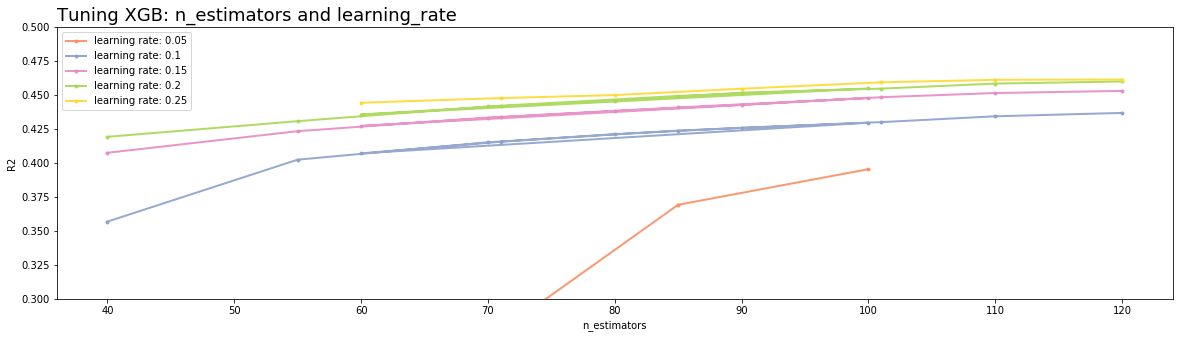

In [31]:
plot_R2_2params('n_estimators', 'learning_rate', xgb_tuning2[xgb_tuning2['num_features']==63])

In [30]:
def plot_R2_2params(param_x, param_color, xgb_tuning,scatter=False):

    fig, ax = plt.subplots(figsize=(20,5))


    palette = plt.get_cmap('Set2')
    num=0
    for learning_rate in xgb_tuning.learning_rate.unique():
        num+=1
        x = (xgb_tuning[xgb_tuning[param_color]==learning_rate][param_x])
        y = (xgb_tuning[xgb_tuning[param_color]==learning_rate]['R2'])
        #labels= (xgb_tuning[xgb_tuning[param_color]==learning_rate][param_color])
        if scatter == False:
            P = plt.plot(x,y, marker='.',color=palette(num), linewidth=2, alpha=0.9,
                 label=('learning rate: ' +str(learning_rate)))
        if scatter == True:
            P = plt.scatter(x,y, marker='o',color=palette(num),
                 label=('learning rate: ' +str(learning_rate)))
        
    plt.legend(loc=2, ncol=1)
    plt.title(("Tuning XGB: "+ param_x +" and "+param_color), loc='left', fontsize=18, fontweight=0, color='black')

    plt.xlabel(param_x)
    plt.ylabel("R2")
    
    # Y lim
    if scatter == False:
        P[0].axes.set_ylim(0.3,0.5)
    if scatter == True:
        P.axes.set_ylim(0.3,0.5)

In [23]:
xgb_tuning

,Model,num_features,Features,MSE,R2,learning_rate,n_estimators
0,XGB,63,All w/ climzones,-5.497892,-2.089663,0.05,40
1,XGB,5,"[gdp, gdp_per_capita, gpw_population, precip, ...",-5.540515,-2.113769,0.05,40
2,XGB,63,All w/ climzones,-2.066128,-0.157652,0.05,55
3,XGB,5,"[gdp, gpw_population, temp_isothermality, prec...",-2.099935,-0.176934,0.05,55
4,XGB,63,All w/ climzones,-1.308465,0.269557,0.05,70
5,XGB,5,"[gdp, gpw_population, temp_seasonality, pixel_...",-1.348030,0.246828,0.05,70
6,XGB,63,All w/ climzones,-1.132156,0.369255,0.05,85
7,XGB,5,"[gdp, temp_isothermality, precip, pixel_id_flo...",-1.201914,0.329596,0.05,85
8,XGB,63,All w/ climzones,-1.086096,0.395434,0.05,100
9,XGB,5,"[gpw_population, temp_seasonality, precip, pix...",-1.122087,0.374878,0.05,100


In [24]:
xgb_tuning2

,Model,num_features,Features,MSE,R2,learning_rate,n_estimators
0,XGB,63,All w/ climzones,-5.497892,-2.089663,0.05,40
1,XGB,5,"[gdp, gdp_per_capita, gpw_population, precip, ...",-5.540515,-2.113769,0.05,40
2,XGB,63,All w/ climzones,-2.066128,-0.157652,0.05,55
3,XGB,5,"[gdp, gpw_population, temp_isothermality, prec...",-2.099935,-0.176934,0.05,55
4,XGB,63,All w/ climzones,-1.308465,0.269557,0.05,70
5,XGB,5,"[gdp, gpw_population, temp_seasonality, pixel_...",-1.348030,0.246828,0.05,70
6,XGB,63,All w/ climzones,-1.132156,0.369255,0.05,85
7,XGB,5,"[gdp, gpw_population, temp_isothermality, prec...",-1.182342,0.340756,0.05,85
8,XGB,63,All w/ climzones,-1.086096,0.395434,0.05,100
9,XGB,5,"[gdp, temp_isothermality, precip, pixel_id_flo...",-1.151912,0.357973,0.05,100


### GRID SEARCH

In [ ]:
xgb_regressor = xgb.XGBRegressor()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, .07, .2], #so called `eta` value
              'max_depth': [3, 5, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.5,0.75,1],
              'colsample_bytree': [0.5,0.75,1],
              'n_estimators': [300,500,600]}


xgb_grid = GridSearchCV(xgb_regressor,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

x = df.drop(['calories_per_ha'], axis=1)
y = df['calories_per_ha']

X_train, X_test, y_train, y_test = train_test_split(x, y)
xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [27]:
# Results from cell above
# Fitting 2 folds for each of 243 candidates, totalling 486 fits | elapsed: 16.0min finished
best_R2 = 0.44336470168217684
best_parameters = {'colsample_bytree': 0.75, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 600, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.75}

In [15]:
## Testing XGBoost with params (RESULTS BELOW WITH CLIMZONES)

model = 'XGB'
## Step 2: tuning tree-based parameters

learning_rate = 0.2:
n_estimators = 100:
    
    for min_samples_split in [500 ... ### ~0.5-1% of total values
           for max_depth in range (5,9):                   
                              
                              
        print('Running XGBoost with params:')
        print(' -- Learning Rate = ' + str(learning_rate) +' -- n_estimators = ' + str(n_estimators) + '  -- ')
        
        regression = xgb.XGBRegressor(learning_rate = learning_rate,n_estimators = n_estimators)



        # Doing it will all features
        print('    with all features...')
        num_features = len(df.columns)-2
        Features = 'All w/ climzones'
        
        scores = do_regression(regression,df)

        print('    R2_score : '+str(scores[0]))
        print('    MSE_score : '+str(scores[1]))
        
        R2_score = scores[0]
        MSE_score = scores[1]
        
        xgb_tuning = xgb_tuning.append({'Model': model,
                                        'num_features':len(df.columns)-1,'Features':'All w/ climzones',
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)

        print('    ... done')

        # Iterate over ≠ numbers of features
        for num_features in range (5,6):

            print('    with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)

            x = df.drop(['calories_per_ha'], axis=1) ## TODO climate_zones encode One Hot Encoder
            y = df['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)

            X_RFE = selector.fit_transform(X,Y)

            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            features_selected.append('calories_per_ha')
            scores = do_regression(regression,df[features_selected])
            print('    R2_score : '+str(scores[0]))
            print('    MSE_score : '+str(scores[1]))
            
            R2_score = scores[0]
            MSE_score = scores[1]
            xgb_tuning = xgb_tuning.append({'Model': model,
                                        'num_features':num_features,'Features':features_selected,
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)
    
    
            print('    ... done \n')

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 40  -- 
    with all features...
    R2_score : -2.089662843804917
    MSE_score : -5.497891785362941
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : -2.1137687302130006
    MSE_score : -5.540515274035159
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 55  -- 
    with all features...
    R2_score : -0.15765197131771708
    MSE_score : -2.066127521164086
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : -0.17693431412043975
    MSE_score : -2.0999350521574263
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.2695568240841067
    MSE_score : -1.3084654633817094
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.24682794796441362
    MSE_score : -1.3480304976032282
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.3692546887871212
    MSE_score : -1.1321555945526434
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.32959599838890946
    MSE_score : -1.2019140554971757
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.39543406979017115
    MSE_score : -1.0860957148106405
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.37487769971103746
    MSE_score : -1.1220867679144997
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 40  -- 
    with all features...
    R2_score : 0.3568755734299513
    MSE_score : -1.1540865016318491
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.33138836313537007
    MSE_score : -1.1987909292009942
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 55  -- 
    with all features...
    R2_score : 0.4024393077849405
    MSE_score : -1.0736631189783818
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3684020838923766
    MSE_score : -1.1334497808516975
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.4152563784378427
    MSE_score : -1.0510276712586915
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3809575192703091
    MSE_score : -1.1116828912475083
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.42385247395888526
    MSE_score : -1.0355248404675959
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.39118833435287004
    MSE_score : -1.0934908153792842
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.42963066019295554
    MSE_score : -1.025111013372745
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38952293352533374
    MSE_score : -1.0963676539068627
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 40  -- 
    with all features...
    R2_score : 0.40751395216220654
    MSE_score : -1.0647974257943162
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.37768991407704416
    MSE_score : -1.1169088395379188
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 55  -- 
    with all features...
    R2_score : 0.42339808903564274
    MSE_score : -1.03660639731994
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.37872615797946263
    MSE_score : -1.115428914797226
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.4334264115038796
    MSE_score : -1.018474930134619
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4245190117952139
    MSE_score : -1.0323065439422854
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.4408841688778784
    MSE_score : -1.0049009332531038
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.40569810371729104
    MSE_score : -1.0679044582509585
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.4478456729018415
    MSE_score : -0.992542895942463
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.41457665127855803
    MSE_score : -1.0492828135790908
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 40  -- 
    with all features...
    R2_score : 0.41925708016665186
    MSE_score : -1.0433175953261913
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.38768868857084987
    MSE_score : -1.0997533705864166
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 55  -- 
    with all features...
    R2_score : 0.43077126464876503
    MSE_score : -1.0227604605363927
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3969462517476524
    MSE_score : -1.0830791634372126
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 70  -- 
    with all features...
    R2_score : 0.4416081987218883
    MSE_score : -1.003162141125355
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.3956064139018287
    MSE_score : -1.0851938247561208
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 85  -- 
    with all features...
    R2_score : 0.4493115637278061
    MSE_score : -0.9893101680908662
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4229844017831684
    MSE_score : -1.0361121567436804
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2 -- n_estimators = 100  -- 
    with all features...
    R2_score : 0.4548195624605576
    MSE_score : -0.9791243117655654
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


    R2_score : 0.4292635093682267
    MSE_score : -1.024542445992736
    ... done 



In [205]:
## Testing XGBoost with params -- RESULTS BELOW W/O CLIMATE ZONES

model = 'XGB'
## First choose: learning_rate, n_estimators
for learning_rate in [0.05, 0.1, 0.15, 0.2]:
    for n_estimators in [40,55,70,85,100]:
        print('Running XGBoost with params:')
        print(' -- Learning Rate = ' + str(learning_rate) +' -- n_estimators = ' + str(n_estimators) + '  -- ')
        
        regression = xgb.XGBRegressor(learning_rate = learning_rate,n_estimators = n_estimators)



        # Doing it will all features
        print('    with all features...')
        num_features = len(df.columns)-2
        Features = 'All EXCEPT climzones'
        
        scores = do_regression(regression,df.drop(['climate_zones'], axis=1))

        print('    R2_score : '+str(scores[0]))
        print('    MSE_score : '+str(scores[1]))
        
        R2_score = scores[0]
        MSE_score = scores[1]
        
        xgb_tuning = xgb_tuning.append({'Model': model,
                                        'num_features':num_features,'Features':features_selected,
                                        'learning_rate':learning_rate,'n_estimators':n_estimators,
                                        'R2':R2_score,'MSE':MSE_score},ignore_index=True)

        print('    ... done')

        # Iterate over ≠ numbers of features
        for num_features in range (5,6):

            print('    with '+str(num_features)+ ' features ...')

            ## RFE - Features selection
            selector = RFE(regression, num_features, step=1)

            x = df.drop(['calories_per_ha','climate_zones'], axis=1) ## TODO climate_zones encode One Hot Encoder
            y = df['calories_per_ha']
            X, X_test, Y, Y_test = train_test_split(x, y)

            X_RFE = selector.fit_transform(X,Y)

            features_selected = [X.columns[feature_pos] for feature_pos in selector.get_support(indices=True)]
            features_selected.append('calories_per_ha')
            scores = do_regression(regression,df[features_selected])
            print('    R2_score : '+str(scores[0]))
            print('    MSE_score : '+str(scores[1]))
    
    
            print('    ... done \n')

Running XGBoost with params:
 -- Learning Rate = 0.05      -- n_estimators = 40  -- 
    with all features...
R2_score : -2.0532010678759955
MSE_score : -5.538779158384349
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : -2.062889586949815
MSE_score : -5.557887544404986
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05      -- n_estimators = 55  -- 
    with all features...
R2_score : -0.16055914011633768
MSE_score : -2.11514207387677
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : -0.17510470189948146
MSE_score : -2.142804533705525
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05      -- n_estimators = 70  -- 
    with all features...
R2_score : 0.2568721021318591
MSE_score : -1.3613612548597505
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.24465703273188613
MSE_score : -1.3846076017640911
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05      -- n_estimators = 85  -- 
    with all features...
R2_score : 0.3551451106829767
MSE_score : -1.1840800173783423
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.340300758444985
MSE_score : -1.2126132646480254
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.05      -- n_estimators = 100  -- 
    with all features...
R2_score : 0.3828339739518645
MSE_score : -1.1344433797026887
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.38318223194270556
MSE_score : -1.1346428159359627
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1      -- n_estimators = 40  -- 
    with all features...
R2_score : 0.3463516680733554
MSE_score : -1.1994597007191075
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.3453004373734923
MSE_score : -1.202797215153806
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1      -- n_estimators = 55  -- 
    with all features...
R2_score : 0.39532669392455183
MSE_score : -1.1114288570205484
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.3918343490612521
MSE_score : -1.118887024273955
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1      -- n_estimators = 70  -- 
    with all features...
R2_score : 0.41024265446379743
MSE_score : -1.0842512002993492
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.4057785941786925
MSE_score : -1.0932343404332419
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1      -- n_estimators = 85  -- 
    with all features...
R2_score : 0.4204730811674449
MSE_score : -1.0654301705780096
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.38388666942146155
MSE_score : -1.1334035499676571
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.1      -- n_estimators = 100  -- 
    with all features...
R2_score : 0.4265861120262967
MSE_score : -1.0538964616918975
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.38054955269149404
MSE_score : -1.1383899994725417
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15      -- n_estimators = 40  -- 
    with all features...
R2_score : 0.39846623194483266
MSE_score : -1.1061102390943447
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.3854607453131912
MSE_score : -1.1310923408639488
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15      -- n_estimators = 55  -- 
    with all features...
R2_score : 0.4154575483035595
MSE_score : -1.07463043110042
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.41310179920609924
MSE_score : -1.0800546155691264
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15      -- n_estimators = 70  -- 
    with all features...
R2_score : 0.424505715740767
MSE_score : -1.0577984761219212
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.4017216180416604
MSE_score : -1.1004231222624874
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15      -- n_estimators = 85  -- 
    with all features...
R2_score : 0.4321958678789656
MSE_score : -1.0432812519850299
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.38575156556293444
MSE_score : -1.1281003735463613
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.15      -- n_estimators = 100  -- 
    with all features...
R2_score : 0.44000221969744546
MSE_score : -1.0289767715393634
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.40599996233563795
MSE_score : -1.0923351319583383
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2      -- n_estimators = 40  -- 
    with all features...
R2_score : 0.4148022864868933
MSE_score : -1.0752565464183126
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.4203652862447863
MSE_score : -1.0664630656924234
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2      -- n_estimators = 55  -- 
    with all features...
R2_score : 0.4268735708040213
MSE_score : -1.0528041674047812
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.38082059970216237
MSE_score : -1.1369797256065186
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2      -- n_estimators = 70  -- 
    with all features...
R2_score : 0.43946401597495266
MSE_score : -1.0291915563456207
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.39950378901551514
MSE_score : -1.103668666475499
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2      -- n_estimators = 85  -- 
    with all features...
R2_score : 0.44519683045001096
MSE_score : -1.018385333734493
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.3972179349533541
MSE_score : -1.1065808700047857
    ... done 

Running XGBoost with params:
 -- Learning Rate = 0.2      -- n_estimators = 100  -- 
    with all features...
R2_score : 0.4517768133687852
MSE_score : -1.0055883137860309
    ... done
    with 5 features ...


/Users/charlotteweil1/anaconda/envs/spatialenv/lib/python3.6/site-packages/sklearn/utils/__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


R2_score : 0.4084606552649526
MSE_score : -1.0864325330303806
    ... done 



In [ ]:
(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None

In [ ]:
## First choose: learning_rate, n_estimators
for learning_rate in [0.05, 0.1, 0.15, 0.2]:
    for n_estimators in [40,55,70,85,100]:
        print(' -- Learning Rate = ' + str(learning_rate) + '      -- n_estimators = ' + str(n_estimators) + '  -- ')
        
        regression = xgb.XGBRegressor(learning_rate = learning_rate,n_estimators = n_estimators)


In [ ]:
xgbreg = xgb.XGBRegressor()
#n_estimators=500, learning_rate=00.08, gamma=0, subsample=0.65
#                           colsample_bytree=0.7 # This results in an error
#                          , max_depth=8)

compare_predictions(xgbreg,df,show_df=True,show_plot=True)

In [ ]:
import xgboost as xgb

In [ ]:
xgbreg = xgb.XGBRegressor(objective = "reg:logistic")
compare_predictions(xgbreg,datalice,show_df=True,show_plot=True)

In [ ]:
## Testing xgb.XGBRegressor

datalice = pd.DataFrame (data={'calories_per_ha':[0,2,2,0,9,1,0,2,2,0,9,1,0,2,2,0,9,1,0,2,2,0,9,1],
                               'predictor1':[0,3,3,1,10,10,0,3,3,1,10,10,0,3,3,1,10,10,0,3,3,1,10,10],
                               'predictor2':[1,2,1,0,9,1,0,3,3,1,10,10,0,3,3,1,10,10,0,3,3,1,10,19],
                               'predictor3':[11,21,20,9,91,10,11,21,20,9,91,10,11,21,20,9,91,10,11,21,20,9,91,10],
                               'climate_zones':[11,21,20,9,91,10,11,21,20,9,91,10,11,21,20,9,91,10,11,21,20,9,91,10]})

In [ ]:
datalice.columns

# NOW LET'S TRY REGRESSIONS!

TRY: linear, poly2, poly3, poly2+interact°, poly3+interact°, Ridge (≠ params), Lasso (≠ params), Tree-based approaches

### Without climate_zone dummies

In [ ]:
linreg(dfBin) #old calories_per_cell with feature engineering

In [ ]:
linreg(dfLog) #old calories_per_cell with feature engineering

In [ ]:
linreg(dfLogBin) #old calories_per_cell with feature engineering

In [ ]:
linreg(df)

In [ ]:
#linreg(dfLog)
type(df.iloc[2]['calories_per_ha'].astype(str))



### With climate_zone dummies


In [ ]:
linreg(dfLog)

## (Looking at predicted values)

In [ ]:
dataframe = dfLog

x = dataframe.drop(['calories_per_ha'], axis=1)
y = dataframe['calories_per_ha']
X_train, X_test, y_train, y_test = train_test_split(x, y)

lr = LinearRegression().fit(X_train, y_train)
y_predicted = lr.predict(X_test)

In [ ]:
compare = pd.DataFrame()
compare['y_test'] = y_test
compare['predicted'] = y_predicted 

#Bunch of negative values
compare

In [ ]:
ax = compare.plot.scatter(x='y_test',y='predicted',s=0.5)
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

# 5a' Reproduce Justin's Full reg
*  d$precip_2 <- d$precip ^ 2
            d$precip_3 <- d$precip ^ 3
            d$temperature_2 <- d$temperature ^ 2
            d$temperature_3 <- d$temperature ^ 3
            d$minutes_to_market_2 <- d$minutes_to_market ^ 2
            d$minutes_to_market_3 <- d$minutes_to_market ^ 3
            d$gdp_gecon_2 <- d$gdp_gecon ^ 2
            d$gdp_gecon_3 <- d$gdp_gecon ^ 3
            d$altitude_2 <- d$altitude ^ 2
            d$altitude_3 <- d$altitude ^ 3
            d$slope_2 <- d$slope ^ 2
            d$slope_3 <- d$slope ^ 3
            d$crop_suitability_2 <- d$crop_suitability ^ 2
            d$crop_suitability_3 <- d$crop_suitability ^ 3

In [ ]:
dfFull = pd.DataFrame.copy(dfLog)

#for var in ['precip','temperature','minutes_to_market','gdp_gecon','altitude','slope']:#,'crop_suitability']:
for var in ['bio12','bio1','minutes_to_market_5m','gdp_per_capita_2000_5m','altitude','slope']:#,'crop_suitability']:
    for i in range(2,4):
        dfFull[var+str(i)] = dfFull[var].pow(i)

In [ ]:
#for var in ['precip','temperature','minutes_to_market','gdp_gecon','altitude','slope']:#,'crop_suitability']:
for var in ['bio12','bio1','minutes_to_market_5m','gdp_per_capita_2000_5m','altitude','slope']:#,'crop_suitability']:
    for i in range(2,4):
        dfFull[var+str(i)] = dfFull[var].pow(i)

In [ ]:
dfFull.columns

In [ ]:
linreg(dfFull[['calories_per_ha', 'bio12', 'bio1', 'slope', 'altitude',
       'workability_index', 'toxicity_index', 'rooting_conditions_index',
       'oxygen_availability_index', 'nutrient_retention_index',
       'nutrient_availability_index', 'excess_salts_index', 'gdp_2000',
       'gdp_per_capita_2000_5m', 'minutes_to_market_5m','has_ag',
       'bio13', 'bio122', 'bio123', 'minutes_to_market_5m2',
       'minutes_to_market_5m3', 'gdp_per_capita_2000_5m2',
       'gdp_per_capita_2000_5m3', 'altitude2', 'altitude3', 'slope2',
       'slope3']]) 

In [ ]:
linreg(dfFull) # Without climate zones

# 5b Models: XGBoost

In [ ]:
def xgboost_reg(dataframe):
    ##Must make dummies for categorical variable climate_zone
    #dataframe = pd.get_dummies(dataframe, columns=['climate_zone'])
    #Or just drop column if don't want dummies: (put following line under referecning of x)
    #x = x.drop(['climate_zone'], axis=1)

    x = dataframe.drop(['calories_per_ha'], axis=1)
    y = dataframe['calories_per_ha']
    

    ### XGBoost Regressor
    xgbreg = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

    ### Cross validation R2 score

    cv_scores = cross_val_score(xgbreg, x, y, cv=10)

    print('Mean R2 score: ', np.mean(cv_scores))

##### Without climate zones

In [ ]:
xgboost_reg(dfLog)

In [ ]:
xgboost_reg(dfFull)

##### With climate zones

In [ ]:
xgboost_reg(dfLog)

In [ ]:
dataframe = dfLog

x = dataframe.drop(['calories_per_ha'], axis=1)
y = dataframe['calories_per_ha']
X_train, X_test, y_train, y_test = train_test_split(x, y)

xgbreg = xgb.XGBRegressor(n_estimators=200, learning_rate=0.08, gamma=1, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

xg =  xgbreg.fit(X_train, y_train)
y_predicted = xg.predict(X_test)

compare = pd.DataFrame()
compare['y_test'] = y_test
compare['predicted'] = y_predicted 

#Bunch of negative values

ax = compare.plot.scatter(x='y_test',y='predicted',s=0.5)
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")

In [ ]:
compare

# 5c Tobit (censored regression)

## from https://github.com/jamesdj/tobit/blob/master/tobit.ipynb

from tobit import * --> Learn how to put the next cell tobit.py as a package??

In [ ]:
import math
import warnings

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.stats
from scipy.special import log_ndtr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error


def split_left_right_censored(x, y, cens):
    counts = cens.value_counts()
    if -1 not in counts and 1 not in counts:
        warnings.warn("No censored observations; use regression methods for uncensored data")
    xs = []
    ys = []

    for value in [-1, 0, 1]:
        if value in counts:
            split = cens == value
            y_split = np.squeeze(y[split].values)
            x_split = x[split].values

        else:
            y_split, x_split = None, None
        xs.append(x_split)
        ys.append(y_split)
    return xs, ys


def tobit_neg_log_likelihood(xs, ys, params):
    x_left, x_mid, x_right = xs
    y_left, y_mid, y_right = ys

    b = params[:-1]
    # s = math.exp(params[-1])
    s = params[-1]

    to_cat = []

    cens = False
    if y_left is not None:
        cens = True
        left = (y_left - np.dot(x_left, b))
        to_cat.append(left)
    if y_right is not None:
        cens = True
        right = (np.dot(x_right, b) - y_right)
        to_cat.append(right)
    if cens:
        concat_stats = np.concatenate(to_cat, axis=0) / s
        log_cum_norm = scipy.stats.norm.logcdf(concat_stats)  # log_ndtr(concat_stats)
        cens_sum = log_cum_norm.sum()
    else:
        cens_sum = 0

    if y_mid is not None:
        mid_stats = (y_mid - np.dot(x_mid, b)) / s
        mid = scipy.stats.norm.logpdf(mid_stats) - math.log(max(np.finfo('float').resolution, s))
        mid_sum = mid.sum()
    else:
        mid_sum = 0

    loglik = cens_sum + mid_sum

    return - loglik


def tobit_neg_log_likelihood_der(xs, ys, params):
    x_left, x_mid, x_right = xs
    y_left, y_mid, y_right = ys

    b = params[:-1]
    # s = math.exp(params[-1]) # in censReg, not using chain rule as below; they optimize in terms of log(s)
    s = params[-1]

    beta_jac = np.zeros(len(b))
    sigma_jac = 0

    if y_left is not None:
        left_stats = (y_left - np.dot(x_left, b)) / s
        l_pdf = scipy.stats.norm.logpdf(left_stats)
        l_cdf = log_ndtr(left_stats)
        left_frac = np.exp(l_pdf - l_cdf)
        beta_left = np.dot(left_frac, x_left / s)
        beta_jac -= beta_left

        left_sigma = np.dot(left_frac, left_stats)
        sigma_jac -= left_sigma

    if y_right is not None:
        right_stats = (np.dot(x_right, b) - y_right) / s
        r_pdf = scipy.stats.norm.logpdf(right_stats)
        r_cdf = log_ndtr(right_stats)
        right_frac = np.exp(r_pdf - r_cdf)
        beta_right = np.dot(right_frac, x_right / s)
        beta_jac += beta_right

        right_sigma = np.dot(right_frac, right_stats)
        sigma_jac -= right_sigma

    if y_mid is not None:
        mid_stats = (y_mid - np.dot(x_mid, b)) / s
        beta_mid = np.dot(mid_stats, x_mid / s)
        beta_jac += beta_mid

        mid_sigma = (np.square(mid_stats) - 1).sum()
        sigma_jac += mid_sigma

    combo_jac = np.append(beta_jac, sigma_jac / s)  # by chain rule, since the expression above is dloglik/dlogsigma

    return -combo_jac


class TobitModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.ols_coef_ = None
        self.ols_intercept = None
        self.coef_ = None
        self.intercept_ = None
        self.sigma_ = None

    def fit(self, x, y, cens, verbose=False):
        """
        Fit a maximum-likelihood Tobit regression
        :param x: Pandas DataFrame (n_samples, n_features): Data
        :param y: Pandas Series (n_samples,): Target
        :param cens: Pandas Series (n_samples,): -1 indicates left-censored samples, 0 for uncensored, 1 for right-censored
        :param verbose: boolean, show info from minimization
        :return:
        """
        x_copy = x.copy()
        if self.fit_intercept:
            x_copy.insert(0, 'intercept', 1.0)
        else:
            x_copy.scale(with_mean=True, with_std=False, copy=False)
        init_reg = LinearRegression(fit_intercept=False).fit(x_copy, y)
        b0 = init_reg.coef_
        y_pred = init_reg.predict(x_copy)
        resid = y - y_pred
        resid_var = np.var(resid)
        s0 = np.sqrt(resid_var)
        params0 = np.append(b0, s0)
        xs, ys = split_left_right_censored(x_copy, y, cens)

        result = minimize(lambda params: tobit_neg_log_likelihood(xs, ys, params), params0, method='BFGS',
                          jac=lambda params: tobit_neg_log_likelihood_der(xs, ys, params), options={'disp': verbose})
        if verbose:
            print(result)
        self.ols_coef_ = b0[1:]
        self.ols_intercept = b0[0]
        if self.fit_intercept:
            self.intercept_ = result.x[1]
            self.coef_ = result.x[1:-1]
        else:
            self.coef_ = result.x[:-1]
            self.intercept_ = 0
        self.sigma_ = result.x[-1]
        return self

    def predict(self, x):
        return self.intercept_ + np.dot(x, self.coef_)

    def score(self, x, y, scoring_function=mean_absolute_error):
        y_pred = np.dot(x, self.coef_)
        return scoring_function(y, y_pred)

In [ ]:
dataframe = dfLog

x = dataframe.drop(['calories_per_cell','climate_zone'], axis=1)
y = dataframe['calories_per_cell']
X_train, X_test, y_train, y_test = train_test_split(x, y)

##Unsure about this 'cens' part
cens = pd.Series(np.zeros((len(y_train),)))
cens[left] = -1
cens[right] = 1
##See below

tob = TobitModel().fit(X_train, y_train,cens)
y_predicted = tob.predict(X_test)

In [ ]:
compare = pd.DataFrame()
compare['y_test'] = y_test
compare['predicted'] = y_predicted 

#Bunch of negative values

In [ ]:
## WTF? : below

In [ ]:
(len(y))

In [ ]:
cens = pd.Series(np.zeros((20,)))

In [ ]:
cens[left] = -1
cens[right] = 1

In [ ]:
cens

## from 